In [96]:
%matplotlib inline
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import bz2
import os
import torch
from llama_cpp import Llama
import kagglehub

from transformers import pipeline
device = 0 if torch.cuda.is_available() else -1

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", device=device)

# Download latest version
twofour_path = kagglehub.dataset_download("sayelabualigah/high-quality-financial-news-dataset-for-nlp-tasks")
# https://huggingface.co/datasets/Zihan1004/FNSPID/tree/main/Stock_news

#print(path)
path = os.path.join("D:\\","Downloads")
#trimmed_path = os.path.join(path, "trimmed1.csv")
#csv_file_path = os.path.join(path, "All_external.csv")
df_seven_path = os.path.join(path, "2007.csv")
df_eight_path = os.path.join(path, "2008.csv")
df_twofour_path = os.path.join(twofour_path, "dataset.csv")
yearDict = {}

if os.path.exists(df_seven_path) and os.path.exists(df_eight_path) and os.path.exists(twofour_path):
    try:
        yearDict["2007"] = pd.read_csv(df_seven_path)
        yearDict["2008"] = pd.read_csv(df_eight_path)
        yearDict["2024"] = pd.read_csv(df_twofour_path)
        #df = pd.read_csv(trimmed_path)
    except Exception as e:
        print(e)
else:
    print("File not found")



Device set to use cuda:0


In [8]:
# Iterate through dataframe for all entries of 2007 and 2008, takes waaay too long to finish though
# So interrupt after some hours, does not matter since sentiment analysis takes too much time for this data anyways

yearDict = {}
yearDict["2007"] = pd.DataFrame(columns=df.columns)
yearDict["2008"] = pd.DataFrame(columns=df.columns)


for _, row in df.iterrows():
    date = row["Date"][:4]
    if(date in yearDict):
        yearDict[date] = pd.concat([yearDict[date], pd.DataFrame([row])], ignore_index=True)
        #if(yearDict[date].shape[0] >= 50000):
        #    break
        

print(yearDict)

Index(['Date', 'Article_title'], dtype='object')


KeyboardInterrupt: 

In [ ]:
# Save the results of previous cell, even if it did not run to completion
if df is not None:
    seven_path = os.path.join(path, "2007.csv")
    eight_path = os.path.join(path, "2008.csv")


    yearDict["2007"].to_csv(seven_path, index=False)
    yearDict["2008"].to_csv(eight_path, index=False)

In [120]:
# DATA PRE-PROCESSING
# Dataset contained a lot of russian articles, remove them
# Crash of 2008 happened 15 september, so filter out articles which happened after 14th, EDIT: keep them and make data month-wise instead
from datetime import datetime
import pytz
import re

def filter_out_cyrillic(df, column_name):
    cyrillic_pattern = re.compile('[\u0400-\u04FF]')
    filtered_df = df[~df[column_name].str.contains(cyrillic_pattern)]
    return filtered_df

yearDict["2024"] = yearDict["2024"][:-1]
# convert dataframe items to date objects
yearDict["2007"]["Date"] = pd.to_datetime(yearDict["2007"]["Date"], format="%Y-%m-%d %H:%M:%S %Z", utc=True)
yearDict["2008"]["Date"] = pd.to_datetime(yearDict["2008"]["Date"], format="%Y-%m-%d %H:%M:%S %Z", utc=True)
yearDict["2024"]["Date"] = pd.to_datetime(yearDict["2024"]["Date"], format="mixed", utc=True)

# 2024 data is from another data set, fix the formatting
yearDict["2024"] = yearDict["2024"].rename(columns={'CompactedSummary': 'Article_title'})
yearDict["2024"] = yearDict["2024"].dropna(subset=['Article_title'])

#crash_date = datetime(2008, 9, 15, tzinfo=pytz.UTC)
#pre_crash_eight_df = yearDict["2008"][yearDict["2008"]["Date"] < crash_date]

# filter for cyrillic alphabet
seven_filtered = filter_out_cyrillic(yearDict["2007"], "Article_title")
eight_filtered = filter_out_cyrillic(yearDict["2008"], "Article_title")


# Divide data into month-wise instead of year-wise
month_dict = {}
for i in range(1, 13):
    iter_month = datetime(2007, i, 1)
    month_dict[iter_month] = seven_filtered[seven_filtered["Date"].dt.month == iter_month.month]

for i in range(1, 13):
    iter_month = datetime(2008, i, 1)
    month_dict[iter_month] = eight_filtered[eight_filtered["Date"].dt.month == iter_month.month]

for i in range(3, 7):
    iter_month = datetime(2024, i, 1)
    month_dict[iter_month] = yearDict["2024"][yearDict["2024"]["Date"].dt.month == iter_month.month]


In [ ]:
# CPU times
# 2.9s for 100 elements
# 29s for 1000 elements
# 290s for 10 000 elements?
# 2900s for 100 000 elements??

# GPU times (Both 2007 and 2008 now, so double workload compared to CPU tests)
# 34.8s for 1000 elements
# 360s for 10 000 elements
# 3600s for 100 000 elements ? 

# Times for monthly sampling using GPU
# 0.8 min for nr = 100
# 5.5 min for nr = 1000
# 67 min for nr = 10 000

# Nr of samples / month, workload is effectively 30 * nr
nr = 10000

result_dict = {}
for key, value in month_dict.items():
    if len(value) >= nr:
        result_dict[key] = pipe(value['Article_title'].sample(n=nr).tolist())
    else:
        result_dict[key] = pipe(value['Article_title'].tolist())
        print(len(value), key)

425 2024-03-01 00:00:00
300 2024-04-01 00:00:00
793 2024-05-01 00:00:00
282 2024-06-01 00:00:00


In [ ]:
# Save results to json file
import json
file_name = 'results.json'
result_dict_str_keys = {date.strftime("%Y-%m-%d"): value for date, value in result_dict.items()}
with open(file_name, 'w') as file:
    json.dump(result_dict_str_keys, file, indent=4)

Dictionary saved to results.json


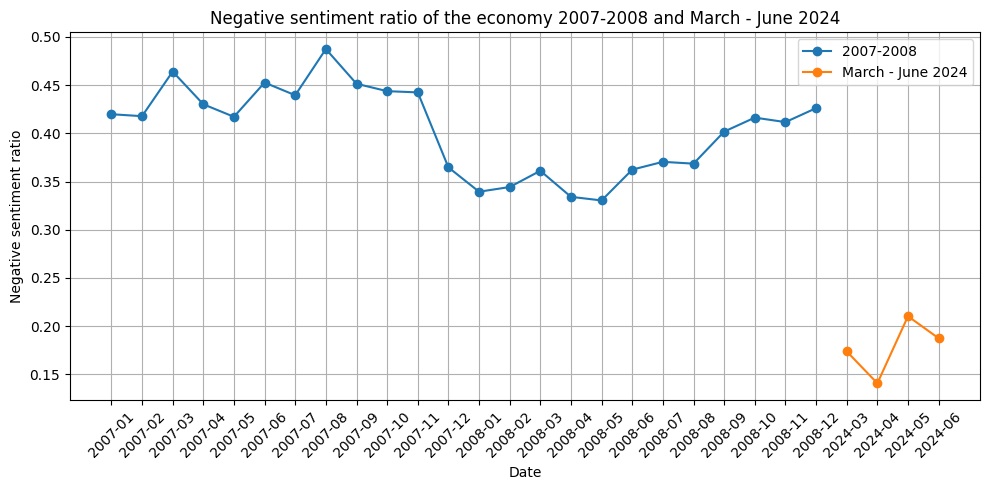

In [141]:
import matplotlib.pyplot as plt

month_ratios = {}
for date, results in result_dict.items():
    label_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
    for result in results:
        label_counts[result['label']] += 1
    month_ratios[date] = label_counts['negative'] / (label_counts['positive'] + label_counts['negative'])

dates = []
for date in month_ratios.keys():
    year_month = date.strftime("%Y-%m")
    dates.append(year_month)

values = list(month_ratios.values())

plt.figure(figsize=(10, 5))

plt.plot(dates[:24], values[:24], marker='o', label='2007-2008')
plt.plot(dates[24:], values[24:], marker='o', label='March - June 2024')

plt.xlabel('Date')
plt.ylabel('Negative sentiment ratio')
plt.title('Negative sentiment ratio of the economy 2007-2008 and March - June 2024')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()
plt.show()


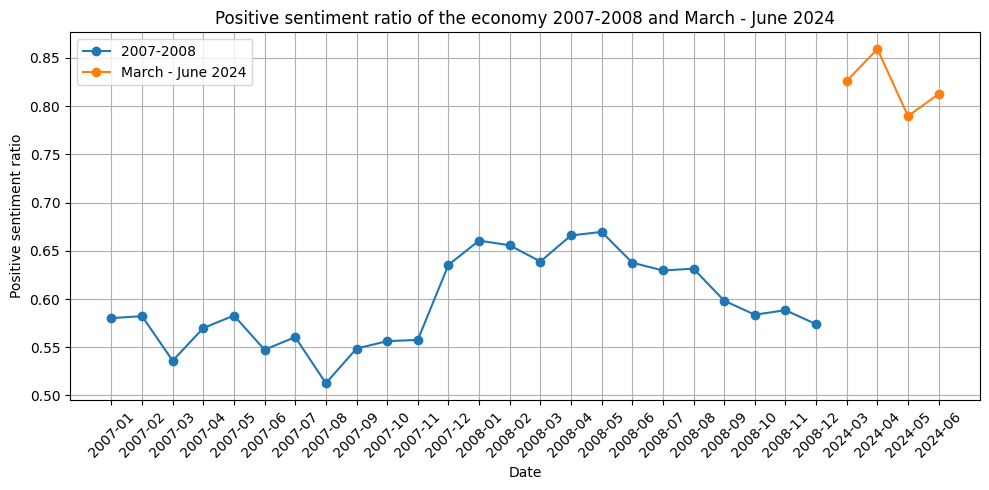

In [142]:
import matplotlib.pyplot as plt

month_ratios = {}
for date, results in result_dict.items():
    label_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
    for result in results:
        label_counts[result['label']] += 1
    month_ratios[date] = label_counts['positive'] / (label_counts['positive'] + label_counts['negative'])

dates = []
for date in month_ratios.keys():
    year_month = date.strftime("%Y-%m")
    dates.append(year_month)

values = list(month_ratios.values())

plt.figure(figsize=(10, 5))

plt.plot(dates[:24], values[:24], marker='o', label='2007-2008')
plt.plot(dates[24:], values[24:], marker='o', label='March - June 2024')

plt.xlabel('Date')
plt.ylabel('Positive sentiment ratio')
plt.title('Positive sentiment ratio of the economy 2007-2008 and March - June 2024')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()
plt.show()